In [4]:
import torch
import torch.nn as nn
from torch import tensor
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.transforms import v2
%matplotlib inline

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 
    'worm'
]


Files already downloaded and verified
Files already downloaded and verified


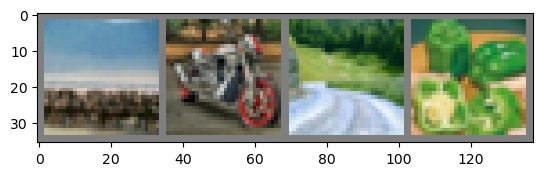

plain motorcycle  road sweet_pepper


In [6]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


# Resnet-18 with MultiHead with ADAM

In [20]:
import torch
import torch.nn as nn
import torchvision.models as models

class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, in_dim, heads):
        super(MultiHeadAttentionWrapper, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=in_dim, num_heads=heads, batch_first=True)

    def forward(self, x):
        # Store original shape
        original_shape = x.shape  # New line to store original shape

        # Reshape x for attention
        batch_size, channels, height, width = x.size()
        x = x.flatten(2).permute(0, 2, 1)

        # Apply attention
        attn_output, _ = self.attention(x, x, x)

        # Restore attn_output to original shape
        attn_output = attn_output.permute(0, 2, 1).contiguous()
        attn_output = attn_output.view(batch_size, channels, height, width)

        # Restore x to its original shape
        x = x.permute(0, 2, 1).contiguous().view(original_shape)  # New line to restore x's shape

        return attn_output + x


In [21]:
import torch
import torch.nn as nn
import torchvision.models as models

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Load pretrained ResNet-18
        self.resnet = models.resnet18(pretrained=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 100)

        # Modify layers to include multi-head attention
        self.layer1 = self._add_attention_to_layer(self.resnet.layer1, 64, 2)
        self.layer2 = self._add_attention_to_layer(self.resnet.layer2, 128, 4)
        self.layer3 = self._add_attention_to_layer(self.resnet.layer3, 256, 8)
        self.layer4 = self._add_attention_to_layer(self.resnet.layer4, 512, 8)

    def _add_attention_to_layer(self, layer, in_dim, heads):
        new_layer = []
        for block in layer:
            new_layer.append(block)
            new_layer.append(MultiHeadAttentionWrapper(in_dim, heads))
        return nn.Sequential(*new_layer)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet.fc(x)

        return x

# Assuming 'device' is defined (e.g., 'cuda' or 'cpu')
net = Net()
net.to(device)

Net(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [5]:
import torch.optim as optim

# Your existing loss function remains the same
loss_func = nn.CrossEntropyLoss()

# Initialize the Adam optimizer
opt = optim.Adam(net.parameters(), lr=0.001)

NameError: name 'nn' is not defined

In [1]:
avg_losses = []   # Avg. losses.
epochs = 100       # Total epochs.
print_freq = 1000  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

NameError: name 'trainloader' is not defined

In [2]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

NameError: name 'plt' is not defined

In [3]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the X test images: %d %%' % (
    100 * correct / total))

NameError: name 'torch' is not defined